# Channel Flow (Steady) DEMO code

This notebook demonstrates solving steady-state channel flow (uniform inlet) using Physics-Informed Neural Networks (PINNs).

In [1]:
import deepflow as df

## 1. Define Geometry Domain
Set up the computational domain: a rectangle with a circular obstacle (cylinder). This defines the area for simulation.

In [2]:
rectangle = df.Geometry.rectangle([0,2], [0,0.5])

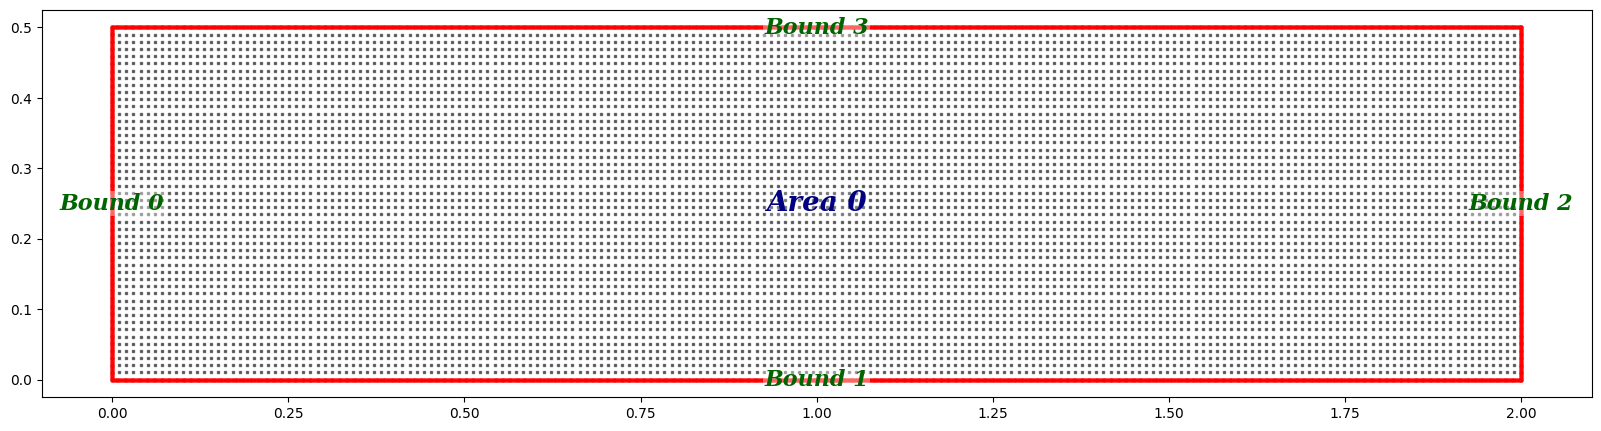

In [3]:
domain = df.domain(rectangle.bound_list, rectangle)
domain.show_setup()

## 2. Define Physics
Define the Navier-Stokes equations for fluid flow and apply boundary conditions (e.g., no-slip walls, inlet velocity).

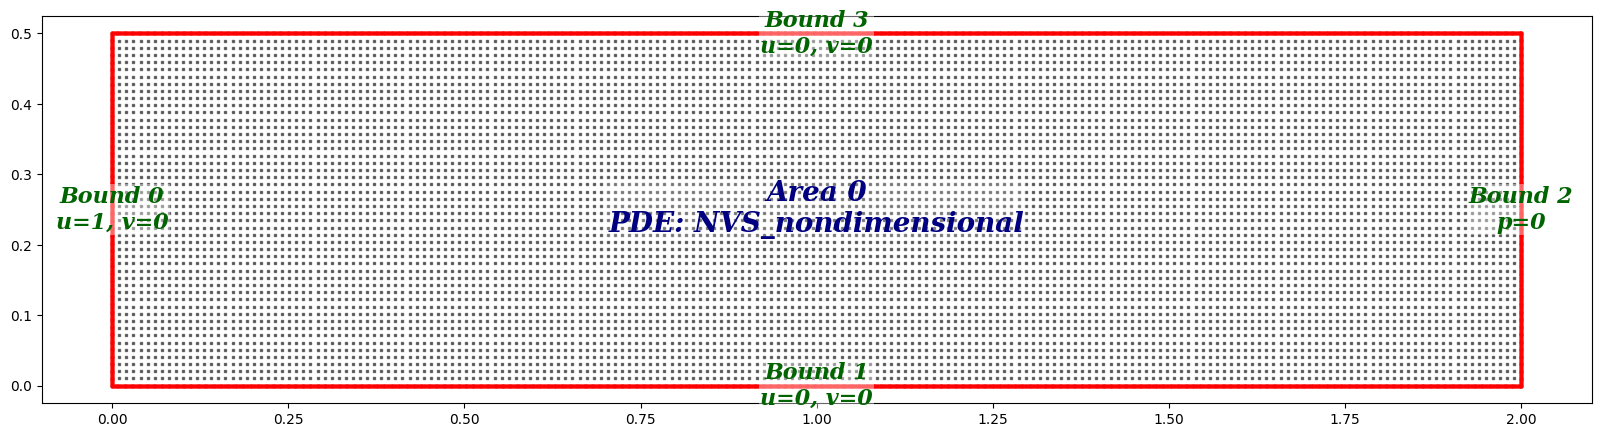

In [4]:
domain.bound_list[0].define_bc({'u':1,'v':0})
domain.bound_list[1].define_bc({'u':0,'v':0})
domain.bound_list[2].define_bc({'p':0})
domain.bound_list[3].define_bc({'u':0,'v':0})
domain.area_list[0].define_pde(df.NVS_nondimensional(U=0.0001, L=1, mu=0.001, rho=1000))
domain.show_setup()


Sample initial points for training. Required if using Residual-based Adaptive Refinement (RAR).

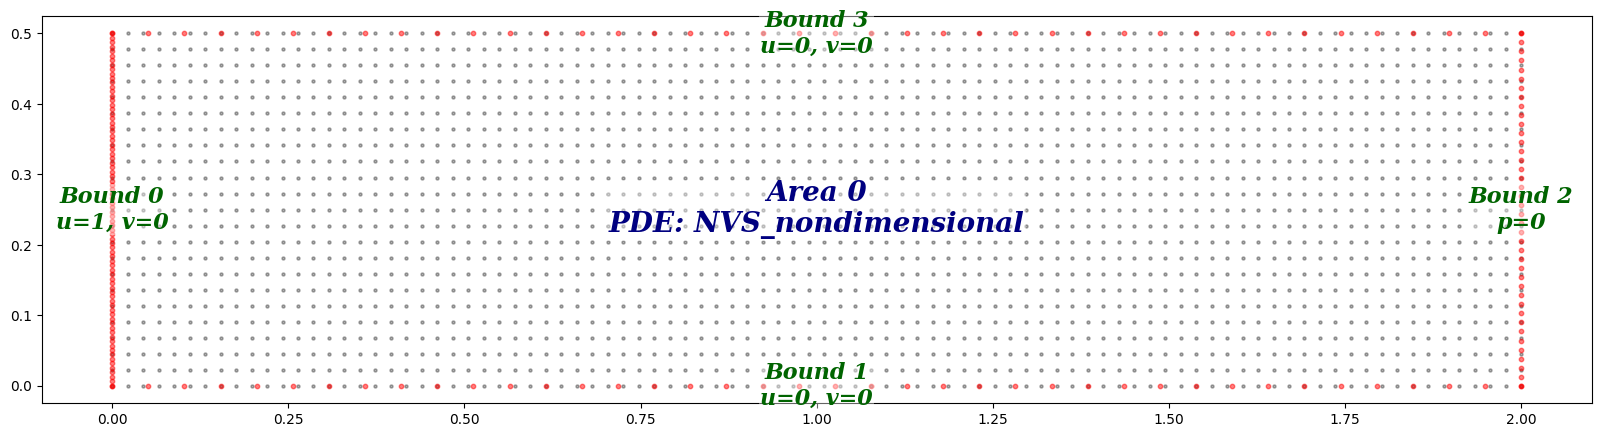

In [5]:
domain.sampling_uniform([80, 40, 40, 40], [[92,23]])
domain.show_coordinates(display_conditions=True)

## 3. Train the PINN model
Initialize a PINN with specified width and depth.

In [6]:
model0 = df.PINN(width=40, length=8)

Design how to compute loss from boundary conditions and PDE residuals

In [7]:
# Define the loss calculation function
N = 0
def calc_loss(model):
    global N
    N += 1

    # # Add collocation points using RAR scheme
    # if N % 1000==0:
    #     print(f'sampling RAR at {N}')
    #     domain.sampling_RAR([4, 4, 4, 4], [250], model, [20, 20, 20, 20], [1250]) #topk: 10% of candidate points
    
    # BC Loss
    bc_loss = 0.0
    for i, bc in enumerate(domain.bound_list):
        bc_loss += bc.calc_loss(model)

    # PDE Loss
    pde_loss = 0.0
    for i, area in enumerate(domain.area_list):
        pde_loss += area.calc_loss(model)

    # Total Loss
    total_loss = bc_loss + pde_loss # weight bc_loss more

    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss} # MUST RETURN IN THIS FORMAT

Train the model using Adam for initial training (faster convergence).

In [8]:
# Train the model
model1 = model0.train_adam(
    calc_loss=calc_loss,
    learning_rate=0.001,
    epochs=1000,
    print_every=200,
    threshold_loss=0.01,
)

epoch 1, total_loss: 0.79897, bc_loss: 0.79891, pde_loss: 0.00007
epoch 201, total_loss: 0.25568, bc_loss: 0.23303, pde_loss: 0.02264
epoch 401, total_loss: 0.08760, bc_loss: 0.07884, pde_loss: 0.00876
epoch 601, total_loss: 0.05347, bc_loss: 0.04736, pde_loss: 0.00612
epoch 801, total_loss: 0.04572, bc_loss: 0.04167, pde_loss: 0.00405


Refine the model using LBFGS for higher precision.

In [9]:
# # Define a stable loss function for LBFGS (no RAR sampling)
# def calc_loss_lbfgs(model):
#     # BC Loss
#     bc_loss = 0.0
#     for i, bc in enumerate(domain.bound_list):
#         bc_loss += bc.calc_loss(model)

#     # PDE Loss
#     pde_loss = 0.0
#     for i, area in enumerate(domain.area_list):
#         pde_loss += area.calc_loss(model)

#     # Total Loss
#     total_loss = bc_loss + pde_loss 

#     return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss}

In [10]:
# # Train the model
# model2 = NetworkTrainer.train_lbfgs(
#     model=model1,
#     calc_loss=calc_loss_lbfgs,
#     epochs=500,
#     print_every=50,
#     threshold_loss=0.001,
#     device='cuda'
# )

Save or Load the model for later use

In [11]:
import pickle
# # Save model with pickle
# with open("model2.pkl", "wb") as f:
#     pickle.dump(model2, f)

# Load model back
# with open("model2.pkl", "rb") as f:
#     model2 = pickle.load(f)

Show the final sampled points used in training

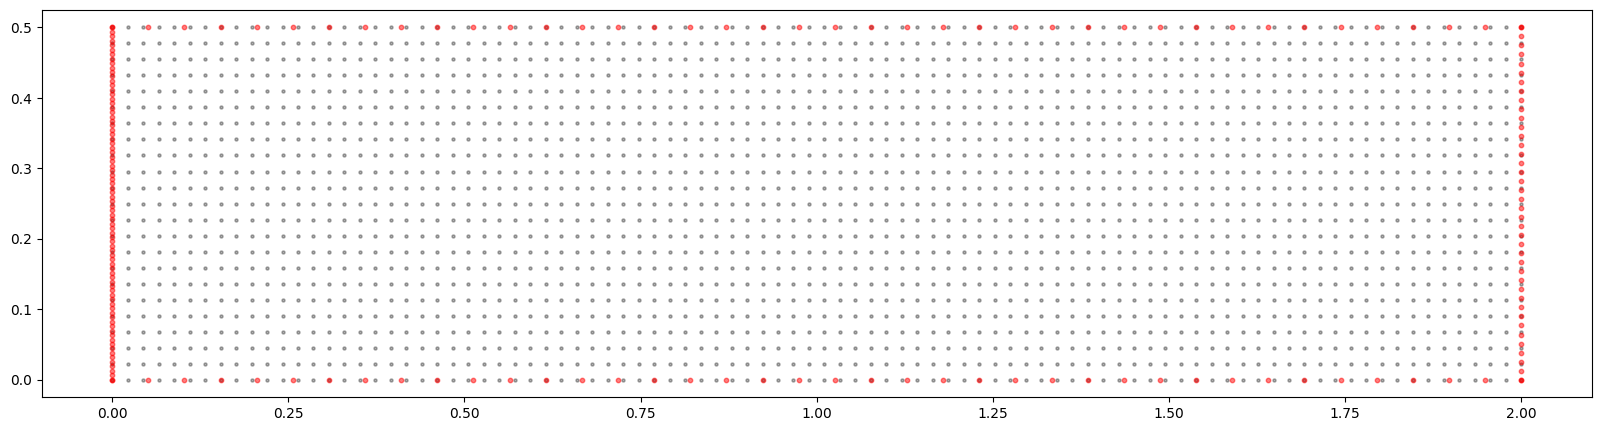

number of bound : 4
        ['0: 80', '1: 40', '2: 40', '3: 40']
        , number of area : 1
        ['0: 2116']


In [12]:
domain.show_coordinates()
print(domain)

## 4. Visualization

### 4.1 Visualize area

In [13]:
from deepflow import Physics, Geometry
area = Geometry.rectangle([0,2], [0,0.5])
area.define_pde(Physics.NVS_nondimensional(U=0.0001, L=1, mu=0.001, rho=1000))

In [14]:
# Create object for evaluation (Need Model and Geometry)
area_visual = area.evaluate(model1)
# Sampling uniform points
area_visual.sampling_area(600, 120)

available_data: ('u', 'v', 'p', 'velocity_magnitude', 'PDE residual', 'x', 'y', 'total_loss', 'bc_loss', 'pde_loss')


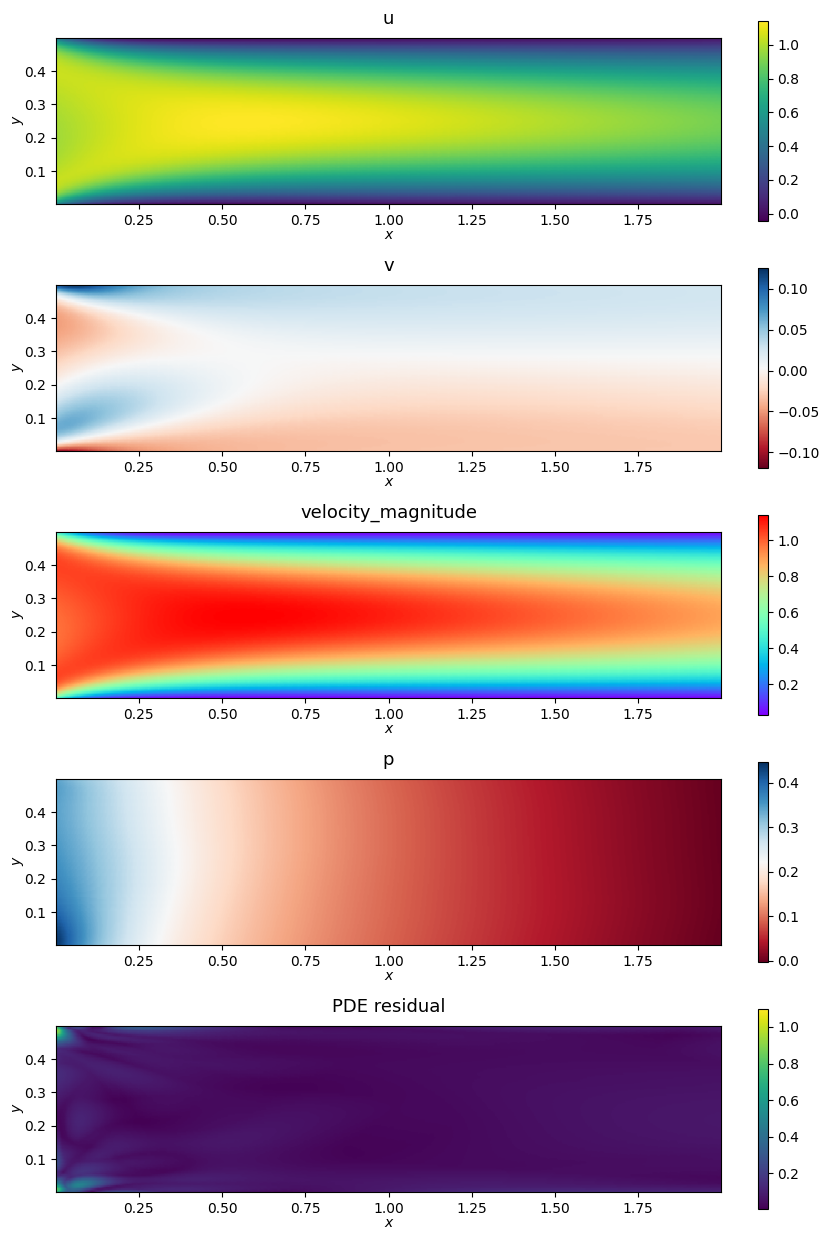

In [15]:
cmap_dict = {
    'u':None,
    'v':'RdBu',
    'velocity_magnitude': 'rainbow',
    'p':'RdBu',
    'PDE residual': 'viridis'
}
colorplot_area_2d = area_visual.plot_data_on_geometry(cmap_dict, s=0.7)
colorplot_area_2d.savefig('colorplot_area_2d.png')

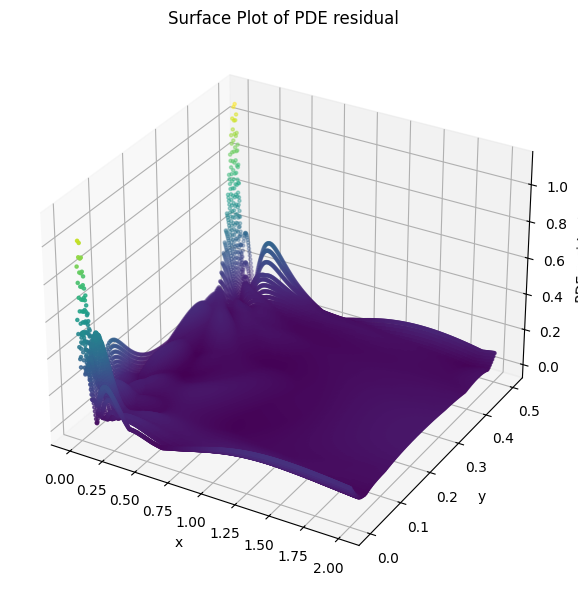

In [16]:
residual_plot_3d = area_visual.plot_data('PDE residual')
residual_plot_3d.savefig('residual_plot_3d.png')

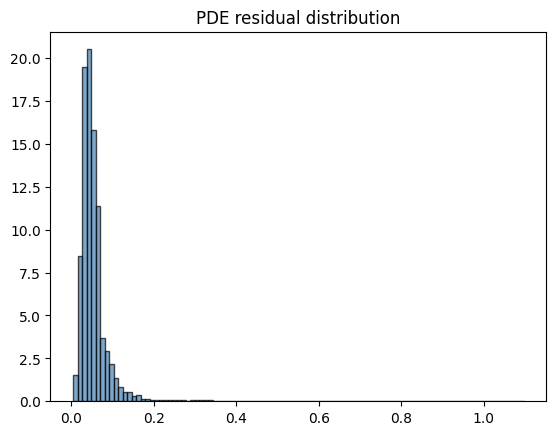

In [17]:
residual_destribution = area_visual.plot_data_distribution('PDE residual', bins=100)

### 4.2 Visualize bound

In [18]:
# Create object for evaluation (Need Model and Geometry)
bound_visual = domain.bound_list[1].evaluate(model2)
# Sampling uniform points
bound_visual.sampling_line(500)

NameError: name 'model2' is not defined

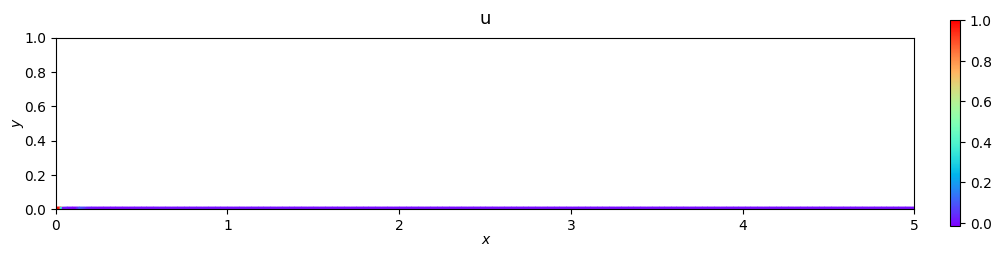

In [ ]:
cmap_dict = {'u':'rainbow'}
colorplot_bound = bound_visual.plot_data_on_geometry(cmap_dict, range_x=[0,5], range_y=[0,1], s=10)
colorplot_bound.savefig('colorplot_bound.png')

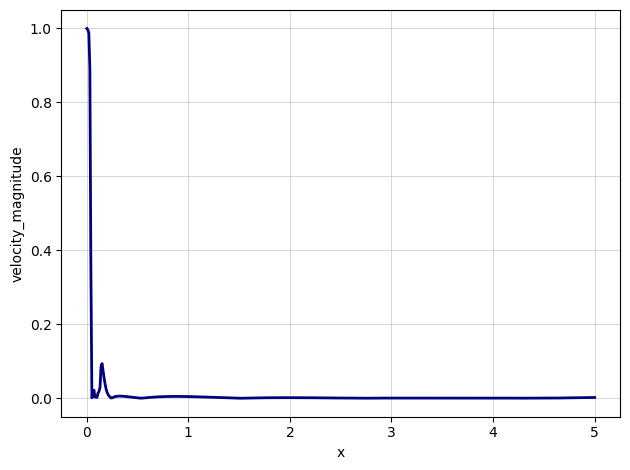

In [ ]:
velocity_plot_outlet = bound_visual.plot_data({'velocity_magnitude':'viridis'}, axis='x')
velocity_plot_outlet.savefig('velocity_plot_outlet.png')

## 4.3 Visualize Neural Network data

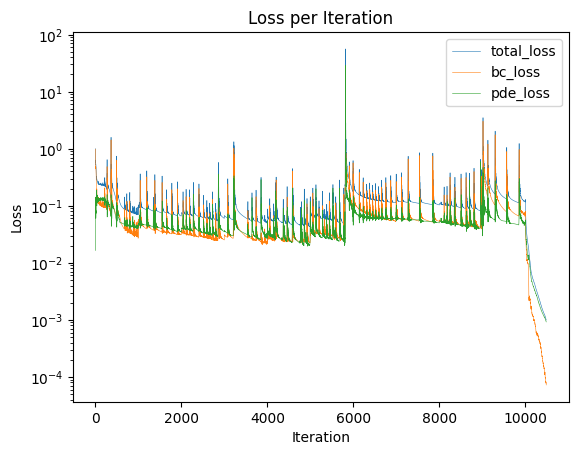

In [ ]:
loss_history = bound_visual.plot_loss_curve(log_scale=True, linewidth=0.4)
loss_history.savefig('loss_history.png')

### 4.4 Export data

In [ ]:
# display available options
print(bound_visual.data_dict.keys())

dict_keys(['u', 'v', 'p', 'velocity_magnitude', 'BC residual', 'x', 'y', 'total_loss', 'bc_loss', 'pde_loss'])


In [ ]:
# store the x,y,velocity_magnitude data
x_data = bound_visual.data_dict['x']
y_data = bound_visual.data_dict['y']
velocity_magnitude_data = bound_visual.data_dict['velocity_magnitude']

#save as txt file
import numpy as np
array = np.column_stack((x_data, y_data, velocity_magnitude_data))
np.savetxt('outlet_velocity_profile.txt', array)